In [1]:
#import os
import sys
sys.path.append("../python/")
from helpers import *
#import pickle
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize
from scipy.special import softmax

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as tkr
from itertools import combinations
from scipy.stats import ttest_ind, f_oneway # for independent t-test

import math

from collections import Counter
import statistics as stat
from matplotlib.ticker import FormatStrFormatter, MaxNLocator

In [3]:
# Globals
NUM_CHANNELS = 3
RESOLUTION_LIST = [336]
SCENARIO_LIST = ["PrPo_Im"] #, "Pr_Im", "Pr_PoIm", "Pr_Po_Im"]
NUM_EPOCHS = 20
AUGMENTATION = 'fliplr'
SAVED_MODEL_DIR = '../../results/models/'
MODEL_PERFORMANCE_METRICS_DIR = '../../results/model-performance/'
FULL_MODEL_PATH = '../../results/models/opt-cnn-base-PrPo_Im-w-336-px-h-336-px/model'

In [4]:
trial_seed = 1
class_labels = getClassLabels("PrPo_Im")

In [5]:
GLOBAL_MODEL = models.load_model(FULL_MODEL_PATH)

In [6]:
IMAGE_SETS_SQUARE_TRAIN = createResolutionScenarioImageDict(RESOLUTION_LIST, SCENARIO_LIST, augmentation=AUGMENTATION, type='train', rectangular = False)
IMAGE_SETS_SQUARE_TEST = createResolutionScenarioImageDict(RESOLUTION_LIST, SCENARIO_LIST, augmentation=AUGMENTATION, type='test', rectangular = False)
IMAGE_SETS_SQUARE_VALIDATION = createResolutionScenarioImageDict(RESOLUTION_LIST, SCENARIO_LIST, augmentation=AUGMENTATION, type='validation', rectangular = False)

{336: {'PrPo_Im': array([[array([[[0.40392157, 0.50980392, 0.32156863],
                [0.4745098 , 0.57647059, 0.33333333],
                [0.56078431, 0.6627451 , 0.35686275],
                ...,
                [0.20784314, 0.27843137, 0.18431373],
                [0.13333333, 0.19607843, 0.14509804],
                [0.1254902 , 0.18823529, 0.1372549 ]],

               [[0.39215686, 0.50980392, 0.29411765],
                [0.52156863, 0.64313725, 0.32941176],
                [0.41568627, 0.53333333, 0.2745098 ],
                ...,
                [0.17647059, 0.23921569, 0.17254902],
                [0.12941176, 0.19607843, 0.14901961],
                [0.11372549, 0.17647059, 0.1372549 ]],

               [[0.25098039, 0.36470588, 0.29411765],
                [0.31372549, 0.41960784, 0.30196078],
                [0.35686275, 0.47058824, 0.31764706],
                ...,
                [0.11372549, 0.16862745, 0.12941176],
                [0.11372549, 0.17647059, 0.12941176

In [7]:
training_images, training_labels = getImageAndLabelArrays(IMAGE_SETS_SQUARE_TRAIN[336]["PrPo_Im"])
test_images, test_labels = getImageAndLabelArrays(IMAGE_SETS_SQUARE_TEST[336]["PrPo_Im"])
validation_images, validation_labels = getImageAndLabelArrays(IMAGE_SETS_SQUARE_VALIDATION[336]["PrPo_Im"])

In [8]:
training_images = np.concatenate((training_images,validation_images))
training_labels = np.concatenate((training_labels,validation_labels))

In [9]:
m = GLOBAL_MODEL

In [10]:
def getQuickPredictions():
    x_test = test_images.copy()
    x_test = np.squeeze(x_test)
    y_pred = m.predict(x_test)
    df = pd.DataFrame(y_pred, columns = ['class 0', 'class 1'])
    return df

In [11]:
getQuickPredictions()

class 0   class 1
0    0.337132  0.662868
1    0.558997  0.441003
2    0.714647  0.285353
3    0.716542  0.283458
4    0.543280  0.456721
..        ...       ...
166  0.512333  0.487667
167  0.277936  0.722064
168  0.262147  0.737853
169  0.236584  0.763416
170  0.179460  0.820540

[171 rows x 2 columns]

In [12]:
def generateGradcam(index): 
    cam_img = index # class activation map corresponds to the specified image index 
    probPrediction = [] # store probability of prediction by the CNN
    predictedClass = [] # store CNN-predicted class 
    # class_labels = getClassLabels("PrPo_Im")
    print("Observed image class: ", class_labels[np.argmax(test_labels[cam_img])])
    m = GLOBAL_MODEL
    def loss(output):
        """Returns score corresponding to class of given image index"""                                       
        print("Loss output: ", output) ##
        loss_list = [output[i][j] for i, j in enumerate([np.argmax(j) for j in test_labels[cam_img] ])]
        print(loss_list)
        probPrediction.append(str([np.round(max(softmax(loss)), 2) for loss in output.numpy()])[1:-1])
        predictedClass.append(class_labels[np.argmax([softmax(loss) for loss in output.numpy()])])
        print('Probability of prediction: ', probPrediction)
        print('Predicted class: ', predictedClass)
        print([softmax(loss) for loss in output.numpy()])
        return loss_list

    # print('Class labels: ', class_labels)
    
    # Model_modifier function required for gradcam
    def model_modifier(model):
        """Remove softmax activation of last layer in model"""
        model.layers[-1].activation = tf.keras.activations.linear # Assign linear activation function (pass-through) to the activation of layer at -1
        return model
    
    gradcam_image = np.squeeze(test_images[cam_img])
    gradcam = Gradcam(m, model_modifier = model_modifier)
    cam = gradcam(loss, gradcam_image, penultimate_layer = -1) # Penultimate layer is a fully-connected hidden layer. 
    cam = normalize(cam)
    cam = np.squeeze(cam) # replace np.squeeze 
    print(gradcam_image.shape)
    print("Shape of heatmap matrix:", cam.shape )
    return cam, gradcam_image, probPrediction, predictedClass

In [19]:
def renderGradCam(index, save=False, grid=False, c_map='gist_gray'):
    '''Visualizing gradient-weighted class activation maps as an overlay (heatmap) to the original image.'''
    gradcam_dir = '../../figures/plottingGradCam/6_27_2022/'
    gcam = generateGradcam([index])
    # class_labels = getClassLabels("PrPo_Im")
    save_name = ""
    if grid==False:
        plt.figure(figsize=(5, 5))
        # plt.suptitle('Grad-CAM Index '+str(index)[1:-1]+'\n')
        # plt.title('Observed class: '+class_labels[np.argmax(test_labels[index])], y=-0.08)
        # plt.text(-0.7,-0.05, "Probability of prediction: "+ str("{:.0%}".format(float(str(gcam[2])[2:-2])))+'\n', size=12)
        # plt.text(-0.7,-0.35, 'Predicted class: '+ str(gcam[3])[2:-2], size=12)
        plt.axis('off')
        plt.tight_layout()
        heatmap = np.uint8(cm.jet(gcam[0])[..., :3] * 255)
        plt.imshow(np.squeeze(gcam[1]), cmap=c_map) # remove axes of length one from gradcam_images
        plt.imshow(heatmap, cmap='gist_gray', alpha=0.5) # overlay
        plt.colorbar(label="Grad-CAM Area of Interest", orientation="horizontal")
        plt.tight_layout()
        plt.subplots_adjust(top=0.92)
        plt.show()
    else:
        plt.axis('off')
        plt.tight_layout()
        heatmap = np.uint8(cm.jet(gcam[0])[..., :3] * 255)
        plt.imshow(np.squeeze(gcam[1]), cmap=c_map)
        plt.imshow(heatmap, cmap='gist_gray', alpha=0.5)
    # print(gradcam_dir+"gradcam-"+str(index)[1:-1])
    predicted_class = str(gcam[3])[2:-2]
    observed_class = class_labels[np.argmax(test_labels[index])]
    if predicted_class == "Probable/Possible" and predicted_class == observed_class:
        save_name = "tp"
    elif predicted_class == "Probable/Possible" and predicted_class != observed_class:
        save_name = "fp"
    elif predicted_class == "Improbable" and predicted_class == observed_class:
        save_name = "tn"
    elif predicted_class == "Improbable" and predicted_class != observed_class:
        save_name = "fn"
    print(save_name)
    if save:
        if not os.path.exists(gradcam_dir):
            os.makedirs(gradcam_dir)
        plt.savefig(gradcam_dir+"index_"+str(index)+"_"+save_name+"_"+str("{:.2f}".format(float(str(gcam[2])[2:-2])))+".png")
    print(str(gcam[3])[2:-2])
    return (heatmap)

In [22]:
def analyzePredictions(labels):
    """Returns the indices and prediction probabilities of the test images for both correct and incorrect predictions. 
    The total number for each class should equal the corresponding value in the confusion matrix.
    Currently only scenario PrPo_Im is supported."""
    im = labels[0]
    prPo = labels[1]
    prediction_probabilities = {im+'_correct': [],
                   im+'_incorrect': [],
                   prPo+'_correct':[],
                   prPo+'_incorrect':[]}
    prediction_indices = {im+'_correct': [],
                   im+'_incorrect': [],
                   prPo+'_correct':[],
                   prPo+'_incorrect':[]}
    for i in range(len(test_labels)):
        observed = class_labels[np.argmax(test_labels[i])]
        predicted = str(grad_cam([i])[3])[2:-2]
        pred_prob = grad_cam([i])[2][0]
        if observed == im:
            if predicted == observed:
                prediction_indices[im+'_correct'].append(i)
                prediction_probabilities[im+'_correct'].append(pred_prob)
            else:
                prediction_indices[im+'_incorrect'].append(i)
                prediction_probabilities[im+'_incorrect'].append(pred_prob)
        else:
            if predicted == observed:
                prediction_indices[prPo+'_correct'].append(i)
                prediction_probabilities[prPo+'_correct'].append(pred_prob)
            else:
                prediction_indices[prPo+'_incorrect'].append(i)
                prediction_probabilities[prPo+'_incorrect'].append(pred_prob)
    return prediction_indices, prediction_probabilities

In [14]:
def getPredictionGroups(model, labels, x_test):
    negative_class = labels[0]
    positive_class = labels[1]
    x_test = np.squeeze(x_test)
    y_pred = model.predict(x_test)
    predictions = []
    for p in y_pred:
        predictions.append([class_labels[tf.argmax(p)], np.round(max(p),2)])
    prediction_group = {
        "true_positive": [],
        "false_positive": [],
        "true_negative": [],
        "false_negative": []
    }
    for i in range(len(test_labels)):
        observed_class = class_labels[np.argmax(test_labels[i])]
        predicted_class = predictions[i][0]
        pred_prob = predictions[i][1]
        if observed_class == negative_class:
            if predicted_class == observed_class:
                prediction_group["true_negative"].append((i, pred_prob))
            else:
                prediction_group["false_positive"].append((i, pred_prob))
        else:
            if predicted_class == observed_class:
                prediction_group["true_positive"].append((i, pred_prob))
            else:
                prediction_group["false_negative"].append((i, pred_prob))
    for v in prediction_group.values():
        v.sort(key=lambda x: x[1])
    return prediction_group

Observed image class:  Probable/Possible
Loss output:  tf.Tensor([[-0.7309381  0.5095926]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=0.5095926>]
Probability of prediction:  ['0.78']
Predicted class:  ['Probable/Possible']
[array([0.22434364, 0.77565634], dtype=float32)]
(336, 336, 3)
Shape of heatmap matrix: (336, 336)


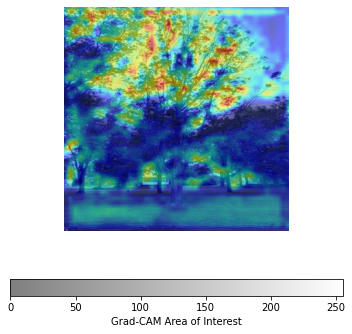

tp
Probable/Possible


array([[[  0, 104, 255],
        [  0, 128, 255],
        [  0, 152, 255],
        ...,
        [  0,  64, 255],
        [  0,  76, 255],
        [  0,  88, 255]],

       [[  0, 120, 255],
        [  0, 148, 255],
        [  0, 172, 255],
        ...,
        [  0,  60, 255],
        [  0,  68, 255],
        [  0,  76, 255]],

       [[  0, 140, 255],
        [  0, 168, 255],
        [  0, 196, 255],
        ...,
        [  0,  56, 255],
        [  0,  60, 255],
        [  0,  64, 255]],

       ...,

       [[  0,   0, 136],
        [  0,   0, 141],
        [  0,   0, 145],
        ...,
        [  0,   0, 255],
        [  0,  12, 255],
        [  0,  28, 255]],

       [[  0,   0, 132],
        [  0,   0, 132],
        [  0,   0, 136],
        ...,
        [  0,   0, 241],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 127],
        [  0,   0, 127],
        [  0,   0, 127],
        ...,
        [  0,   0, 213],
        [  0,   0, 227],
        [  0,   0, 245]]

In [23]:
renderGradCam(113, save=False, grid=False, c_map='plasma')

In [12]:
pred_group = getPredictionGroups(m, class_labels, test_images)

In [15]:
pred_group

{'true_positive': [(106, 0.52),
  (133, 0.58),
  (112, 0.63),
  (125, 0.64),
  (113, 0.72),
  (124, 0.72),
  (117, 0.76),
  (121, 0.82),
  (128, 0.86),
  (136, 0.88),
  (127, 0.89),
  (135, 0.89),
  (107, 0.91),
  (108, 0.91),
  (132, 0.91),
  (110, 0.95),
  (118, 0.96),
  (115, 0.99),
  (119, 0.99),
  (122, 0.99)],
 'false_positive': [(9, 0.52),
  (24, 0.52),
  (52, 0.53),
  (12, 0.55),
  (1, 0.57),
  (48, 0.58),
  (59, 0.6),
  (22, 0.61),
  (44, 0.63),
  (16, 0.64),
  (26, 0.67),
  (104, 0.67),
  (76, 0.68),
  (80, 0.68),
  (83, 0.71),
  (101, 0.71),
  (50, 0.72),
  (97, 0.72),
  (90, 0.73),
  (2, 0.74),
  (25, 0.74),
  (41, 0.77),
  (77, 0.77),
  (35, 0.78),
  (45, 0.78),
  (69, 0.79),
  (92, 0.79),
  (10, 0.81),
  (81, 0.81),
  (21, 0.82),
  (15, 0.83),
  (64, 0.89),
  (89, 0.9),
  (102, 0.92),
  (91, 0.96),
  (20, 0.97),
  (54, 0.97),
  (93, 0.97),
  (70, 0.98),
  (96, 0.98)],
 'true_negative': [(38, 0.51),
  (95, 0.51),
  (84, 0.55),
  (23, 0.56),
  (43, 0.56),
  (51, 0.56),
  (3

In [13]:
def get_summary_statistics(prediction_groups):
    for key,val in prediction_groups.items():
        data = []
        key = key.capitalize().replace("_", " ")
        print(key)
        for v in val:
            data.append(v[1])
        # print(data)
        mean = np.round(stat.mean(data), 2)
        median = np.round(stat.median(data), 2)
        std = np.round(stat.stdev(data), 2)
        min_value = np.round(min(data), 2)
        max_value = np.round(max(data), 2)
        quartile_1 = np.round(np.quantile(data,0.25), 2)
        quartile_3 = np.round(np.quantile(data,0.75), 2)
        # # Interquartile range
        iqr = np.round(quartile_3 - quartile_1, 2)
        print('Min: %s' % min_value)
        print('Max: %s' % max_value)
        print('Mean: %s' % mean)        
        print('Median: %s' % median)
        print('25th percentile: %s' % quartile_1)
        print('75th percentile: %s' % quartile_3)
        print('Interquartile range (IQR): %s' % iqr)
        print('Standard deviation: %s' % std,"\n")

## Print summary statistics for the predictions

In [14]:
get_summary_statistics(pred_group)

True positive
Min: 0.5
Max: 0.52
Mean: 0.51
Median: 0.5
25th percentile: 0.5
75th percentile: 0.51
Interquartile range (IQR): 0.01
Standard deviation: 0.01 

False positive
Min: 0.5
Max: 0.51
Mean: 0.5
Median: 0.5
25th percentile: 0.5
75th percentile: 0.5
Interquartile range (IQR): 0.0
Standard deviation: 0.0 

True negative
Min: 0.5
Max: 0.53
Mean: 0.51
Median: 0.51
25th percentile: 0.51
75th percentile: 0.52
Interquartile range (IQR): 0.01
Standard deviation: 0.01 

False negative
Min: 0.5
Max: 0.52
Mean: 0.51
Median: 0.51
25th percentile: 0.5
75th percentile: 0.51
Interquartile range (IQR): 0.01
Standard deviation: 0.01 



In [15]:
for k,v in pred_group.items():
    print(k,"\n",v,"\n")

true_positive 
 [(140, 0.5), (151, 0.5), (152, 0.5), (153, 0.5), (156, 0.5), (165, 0.5), (170, 0.5), (141, 0.51), (142, 0.51), (143, 0.51), (148, 0.51), (149, 0.51), (147, 0.52), (150, 0.52)] 

false_positive 
 [(11, 0.5), (36, 0.5), (54, 0.5), (77, 0.5), (81, 0.5), (83, 0.5), (88, 0.5), (91, 0.5), (118, 0.5), (120, 0.5), (127, 0.5), (90, 0.51), (102, 0.51), (114, 0.51), (116, 0.51)] 

true_negative 
 [(0, 0.5), (20, 0.5), (28, 0.5), (37, 0.5), (50, 0.5), (55, 0.5), (72, 0.5), (74, 0.5), (75, 0.5), (78, 0.5), (82, 0.5), (84, 0.5), (86, 0.5), (87, 0.5), (89, 0.5), (92, 0.5), (93, 0.5), (94, 0.5), (96, 0.5), (103, 0.5), (113, 0.5), (121, 0.5), (122, 0.5), (123, 0.5), (124, 0.5), (126, 0.5), (128, 0.5), (129, 0.5), (130, 0.5), (138, 0.5), (139, 0.5), (2, 0.51), (5, 0.51), (6, 0.51), (8, 0.51), (9, 0.51), (10, 0.51), (12, 0.51), (14, 0.51), (18, 0.51), (21, 0.51), (22, 0.51), (23, 0.51), (24, 0.51), (25, 0.51), (29, 0.51), (32, 0.51), (34, 0.51), (39, 0.51), (40, 0.51), (41, 0.51), (45, 0.

In [16]:
def returnIdxByProb(group,prob,n):
    indices = []
    for v in pred_group[group]:
        if len(indices) < n:
            if prob == 0.5:
                if(v[1] >= prob) and (v[1] <= prob+0.01):
                    indices.append(v)
            elif prob == 1:
                if(v[1] >= prob-0.01) and (v[1] <= prob):
                    indices.append(v)
            else:
                if(v[1] >= prob-0.01) and (v[1] <= prob + 0.01):
                    indices.append(v)
    return indices

In [17]:
def returnAllGradcamIndices(p_group,n):
    prob = [0.5, 0.6667, 0.833, 1]
    grad_cam_idx = {
        "true_positive": [],
        "false_positive": [],
        "true_negative": [],
        "false_negative": []
    }
    for p in prob:
        for k in p_group.keys():
            grad_cam_idx[k].append((returnIdxByProb(k,p,n),p))
    return grad_cam_idx

In [18]:
gcam_idx = returnAllGradcamIndices(pred_group,4)

In [19]:
gcam_idx

{'true_positive': [([(140, 0.5), (151, 0.5), (152, 0.5), (153, 0.5)], 0.5),
  ([], 0.6667),
  ([], 0.833),
  ([], 1)],
 'false_positive': [([(11, 0.5), (36, 0.5), (54, 0.5), (77, 0.5)], 0.5),
  ([], 0.6667),
  ([], 0.833),
  ([], 1)],
 'true_negative': [([(0, 0.5), (20, 0.5), (28, 0.5), (37, 0.5)], 0.5),
  ([], 0.6667),
  ([], 0.833),
  ([], 1)],
 'false_negative': [([(145, 0.5), (155, 0.5), (162, 0.5), (164, 0.5)], 0.5),
  ([], 0.6667),
  ([], 0.833),
  ([], 1)]}

In [128]:
def generateGradcamForGroup(idx,group):
    print(group, "Grad-CAMs\n")
    for val in idx[group]:
        if len(val[0]) == 0:
            print("No prediction probabilities in the", val[1], "range (+\- 0.01).\n ")
        else:
            print(len(val[0]),"Gradcams for prediction probabilities in the", val[1], "range (+\- 0.01):", [x[0] for x in val[0]],"\n")
            for i in val[0]:
                renderGradCam(i[0],save=True)
            print("\n")

true_positive Grad-CAMs

2 Gradcams for prediction probabilities in the 0.5 range (+\- 0.01): [119, 121] 

Observed image class:  Probable/Possible
Loss output:  tf.Tensor([[-0.07134198 -0.06580316]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=-0.065803155>]
Probability of prediction:  ['0.5']
Predicted class:  ['Probable/Possible']
[array([0.49861526, 0.5013847 ], dtype=float32)]
(336, 336, 3)
Shape of heatmap matrix: (336, 336)
tp
Probable/Possible
Observed image class:  Probable/Possible
Loss output:  tf.Tensor([[-0.28358105 -0.2808027 ]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=-0.2808027>]
Probability of prediction:  ['0.5']
Predicted class:  ['Probable/Possible']
[array([0.49930543, 0.5006946 ], dtype=float32)]
(336, 336, 3)
Shape of heatmap matrix: (336, 336)
tp
Probable/Possible


2 Gradcams for prediction probabilities in the 0.6667 range (+\- 0.01): [107, 114] 

Observed image class:  Probable/Possible
Loss output

C:\Users\nasko\AppData\Local\Temp\ipykernel_11368\754432090.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(5, 5))


fn
Improbable


1 Gradcams for prediction probabilities in the 0.6667 range (+\- 0.01): [111] 

Observed image class:  Probable/Possible
Loss output:  tf.Tensor([[ 0.29330823 -0.36687863]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=-0.36687863>]
Probability of prediction:  ['0.66']
Predicted class:  ['Improbable']
[array([0.6593023 , 0.34069762], dtype=float32)]
(336, 336, 3)
Shape of heatmap matrix: (336, 336)
fn
Improbable


No prediction probabilities in the 0.833 range (+\- 0.01).
 
No prediction probabilities in the 1 range (+\- 0.01).
 


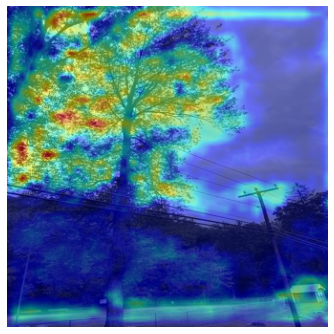

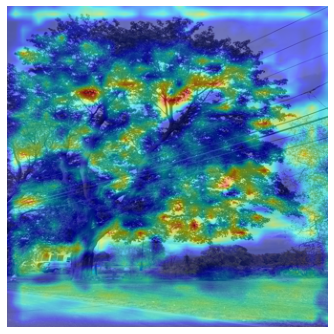

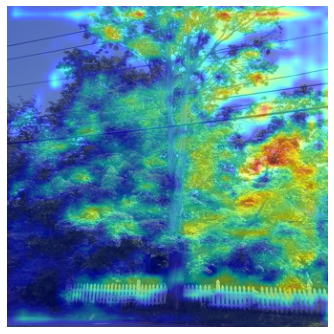

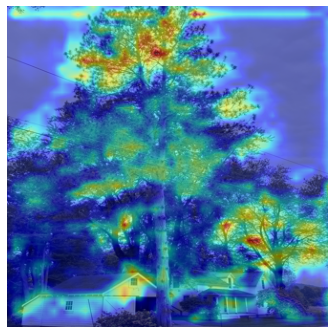

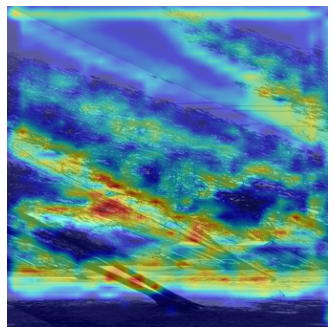

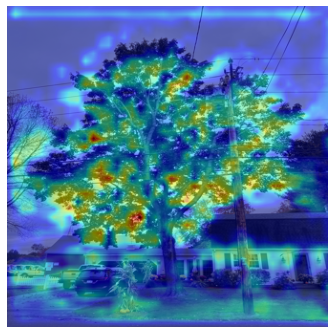

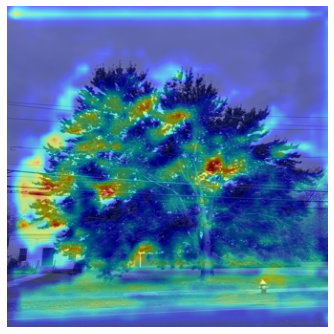

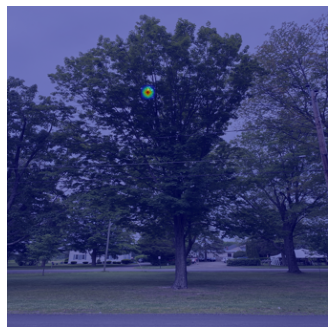

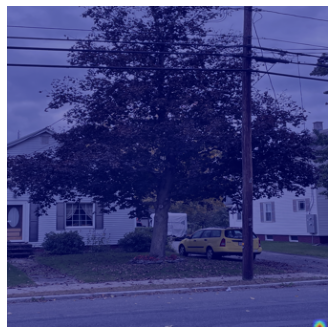

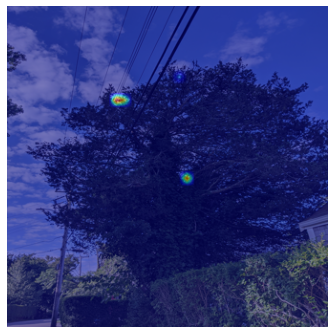

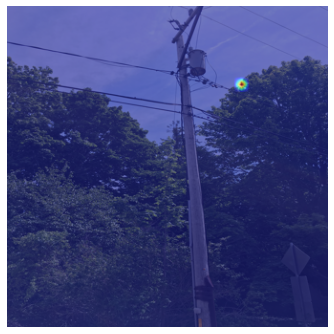

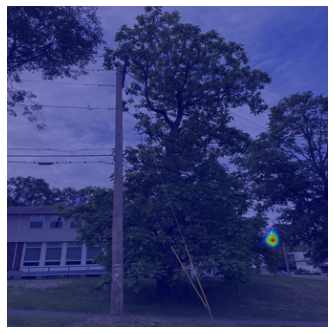

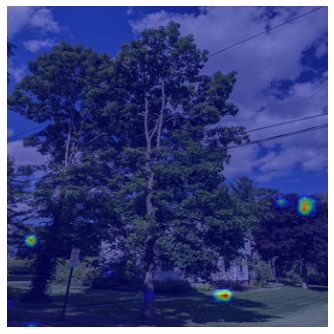

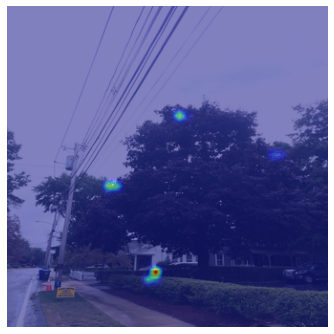

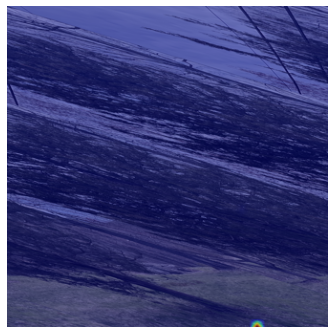

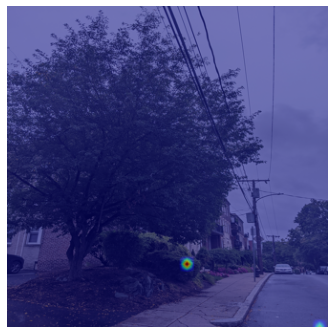

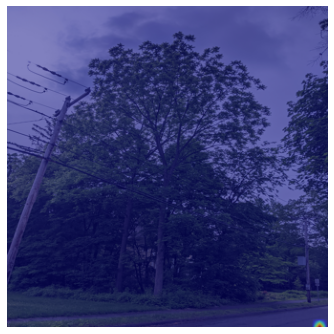

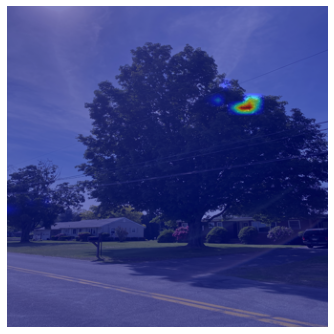

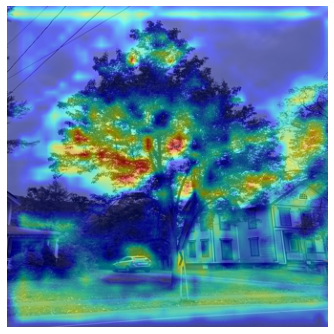

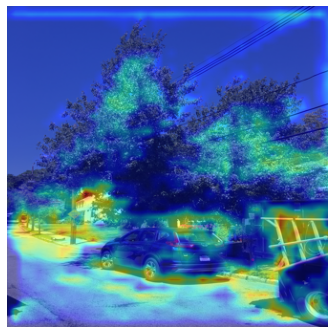

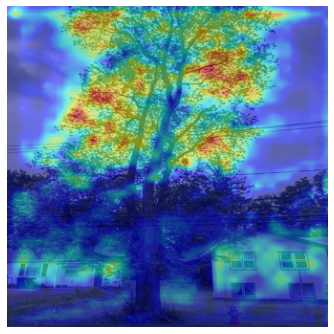

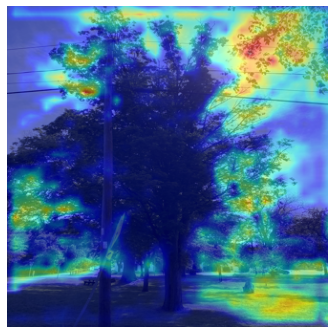

In [129]:
groups = ["true_positive","false_positive","true_negative","false_negative"]
for g in groups:
    generateGradcamForGroup(gcam_idx,g)

In [23]:
def getRates(predictions, to_float_sorted=True):
    tp_ind  = predictions[0][class_labels[1]+'_correct']
    tn_ind  = predictions[0][class_labels[0]+'_correct']
    fp_ind  = predictions[0][class_labels[1]+'_incorrect']
    fn_ind  = predictions[0][class_labels[0]+'_incorrect']
    tp_prob  = predictions[1][class_labels[1]+'_correct']
    tn_prob  = predictions[1][class_labels[0]+'_correct']
    fp_prob  = predictions[1][class_labels[1]+'_incorrect']
    fn_prob  = predictions[1][class_labels[0]+'_incorrect']
    if to_float_sorted:
        tp_prob = sorted([float(x) for x in tp_prob])
        tn_prob = sorted([float(x) for x in tn_prob])
        fp_prob = sorted([float(x) for x in fp_prob])
        fn_prob = sorted([float(x) for x in fn_prob])
    return (tp_ind, tp_prob),(tn_ind, tn_prob),(fp_ind, fp_prob),(fn_ind, fn_prob)

In [24]:
pred_prob = analyzePredictions(class_labels)

Observed image class:  Improbable
Loss output:  tf.Tensor([[-0.15916015 -0.07364872]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=-0.15916015>]
Probability of prediction:  ['0.52']
Predicted class:  ['Probable/Possible']
[array([0.4786352 , 0.52136487], dtype=float32)]
(336, 336, 3)
Shape of heatmap matrix: (336, 336)
Observed image class:  Improbable
Loss output:  tf.Tensor([[-0.15916015 -0.07364872]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=-0.15916015>]
Probability of prediction:  ['0.52']
Predicted class:  ['Probable/Possible']
[array([0.4786352 , 0.52136487], dtype=float32)]
(336, 336, 3)
Shape of heatmap matrix: (336, 336)
Observed image class:  Improbable
Loss output:  tf.Tensor([[-0.10850798 -0.14019151]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=-0.10850798>]
Probability of prediction:  ['0.51']
Predicted class:  ['Improbable']
[array([0.50792015, 0.49207976], dtype=float32)]
(336, 3

In [26]:
tp,fp,tn,fn = getRates(pred_prob)
rates = {"True Positive":tp,
         "False Positive":fp,
         "True Negative":tn,
         "False Negative":fn}

In [111]:
def plotPredictionProbabilities(prediction_group,save_fig=False):
    """Generate summary statistics for True Positive, True Negative, False Positive
    and False Negative Rates"""
    rates = {
        "true_positive": [],
        "false_positive": [],
        "true_negative": [],
        "false_negative": []
    }
    for key,val in prediction_group.items():
        for v in val:
            rates[key].append(v[1])
    fig, ax = plt.subplots(figsize=(12, 7))
    # Remove top and right border
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # Remove y-axis tick marks
    ax.yaxis.set_ticks_position('none')
    # Add major gridlines in the y-axis
    ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
    # Set plot title
    # ax.set_title('Distribution of prediction probabilitiees', fontsize=24)
    data = [rates["true_positive"], rates["false_positive"], rates["true_negative"], rates["false_negative"]]
    lbls = [['TP'],['FP'],['TN'],['FN']]
    bp1 = ax.boxplot(data[0], positions=[0], notch=False, widths=0.35, 
                    patch_artist=True, boxprops=dict(facecolor="#E31A1C"), labels=lbls[0]) #
    # plt.xlabel(lbls[0],fontsize=18)
    bp2 = ax.boxplot(data[1], positions=[1], notch=False, widths=0.35, # median to black
                    patch_artist=True, boxprops=dict(facecolor="#FB9A99"), labels=lbls[1])
    bp3 = ax.boxplot(data[2], positions=[2], notch=False, widths=0.35, 
                    patch_artist=True, boxprops=dict(facecolor="#33A02C"), labels=lbls[2])
    bp4 = ax.boxplot(data[3], positions=[3], notch=False, widths=0.35, 
                    patch_artist=True, boxprops=dict(facecolor="#B2DF8A"), labels=lbls[3])
    # ax.set_ylabel('Prediction Probabilities', fontsize=18)
    ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0], bp4["boxes"][0]], 
              ['True Positive (TP)','False Positive (FP)','True Negative (TN)','False Negative (FN)'], 
              bbox_to_anchor=(1,0.5), loc='center left', prop={'size': 18})
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.grid(which='major', axis='y', linestyle='-', linewidth=0.25, alpha=0.5, zorder=-1.0)
    fig.tight_layout()
    if save_fig:
        plt.savefig('../../figures/boxplot_tp_tn_fp_fn.jpg', dpi=180)
    plt.show()

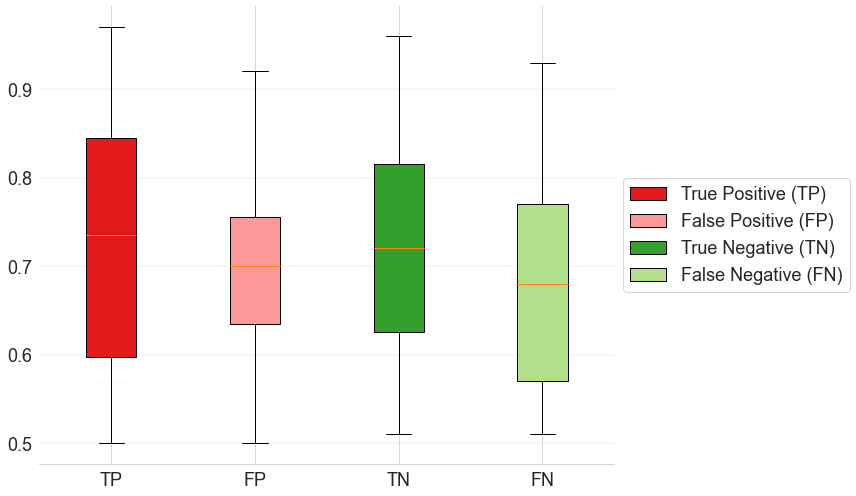

In [95]:
plotPredictionProbabilities(pred_group)

In [32]:
def generateViolinPlot(prediction_group,save_fig=False):
    """Generate a violin plot for True Positive, True Negative, False Positive
    and False Negative Rates"""
    rates = {
        "true_positive": [],
        "false_positive": [],
        "true_negative": [],
        "false_negative": []
    }
    for key,val in prediction_group.items():
        for v in val:
            rates[key].append(v[1])
    df = pd.DataFrame(columns = ['Group', 'Prediction Probability'])
    for key,value in rates.items():
        rates_df = pd.DataFrame({'Group': key.replace("_"," ").capitalize(),
                                 'Prediction Probability':value})
        df = df.append(rates_df, ignore_index=True)
    fig, ax = plt.subplots()
    sns.violinplot(ax = ax,
               data = df,
               palette=['#E31A1C','#FB9A99','#33A02C','#B2DF8A'],
               x = 'Group',
               y = 'Prediction Probability')
    # plt.ylim(0.5,1)
    fig.tight_layout()
    if save_fig:
        plt.savefig('../../figures/violin_plot_tp_tn_fp_fn.png', dpi=180)
    plt.show()

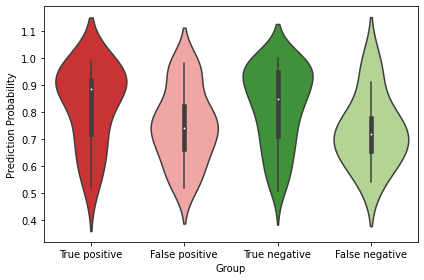

In [33]:
generateViolinPlot(pred_group,True)

In [125]:
def plotProbabilities(outcome, prediction_group, n_bins=10, font_size=22, save_fig=False):
    # tp,fp,tn,fn = getRates(pred_prob)
    # plt.grid(True)
    rates = {
        "true_positive": [],
        "false_positive": [],
        "true_negative": [],
        "false_negative": []
    }
    for key,val in prediction_group.items():
        for v in val:
            rates[key].append(v[1])
    plt.figure(figsize=(15,7)).gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    t = ''
    # plt.grid(which='major', axis='y', zorder=-1.0)  
    if outcome == 'tp':
        t = 'true_positive'
        plt.hist(rates[t], color="#E31A1C", bins=n_bins)
    elif outcome == 'tn':
        t = 'true_negative'
        plt.hist(rates[t], color="#33A02C", bins=n_bins)
    elif outcome == 'fp':
        t = 'false_positive'
        plt.hist(rates[t], color="#FB9A99", bins=n_bins)
    elif outcome == 'fn':
        t = 'false_negative'
        plt.hist(rates[t], color="#B2DF8A", bins=n_bins)
    plt.xlabel('Probabilities', fontsize=font_size)
    plt.ylabel('Counts', fontsize=font_size)
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)
    # plt.title(t, fontsize=24)
    plt.grid(which='major', axis='y', zorder=-1.0)
    plt.tight_layout()
    # plt.title('Prediction probabilities for '+t+' Probable/Possible images')
    if save_fig:
        plt.savefig('../../figures/prpo_'+t+'_predictions_dist.jpg', dpi=180)

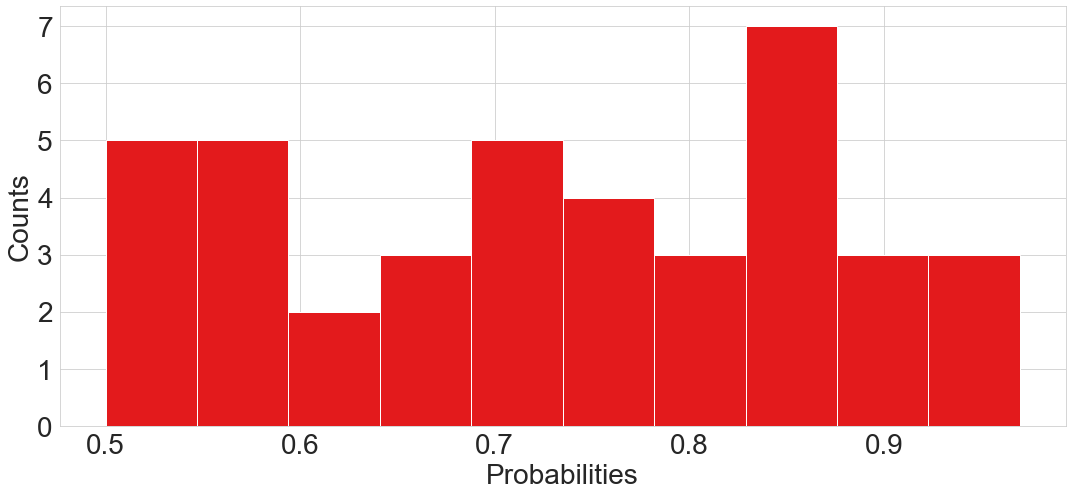

In [124]:
plotProbabilities('tp', pred_group,font_size=28, n_bins=10)

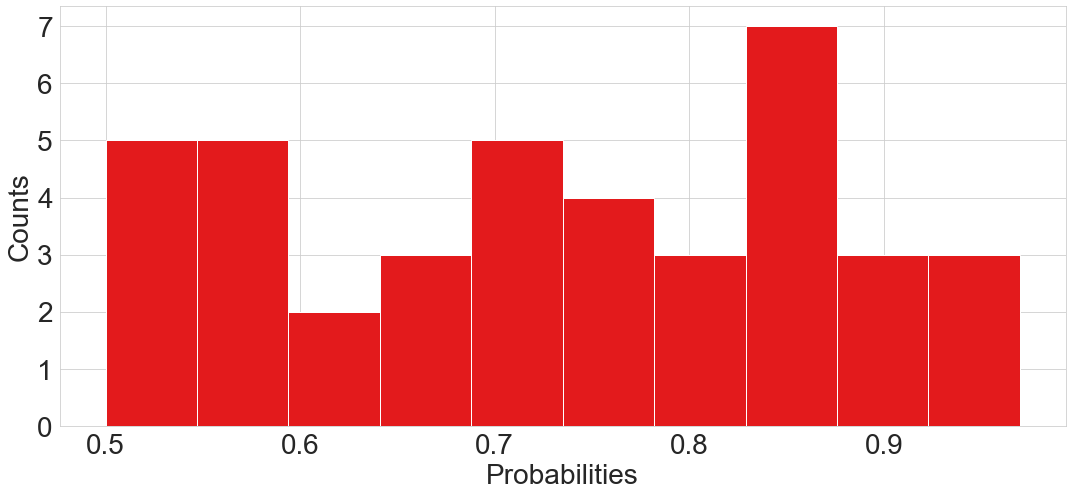

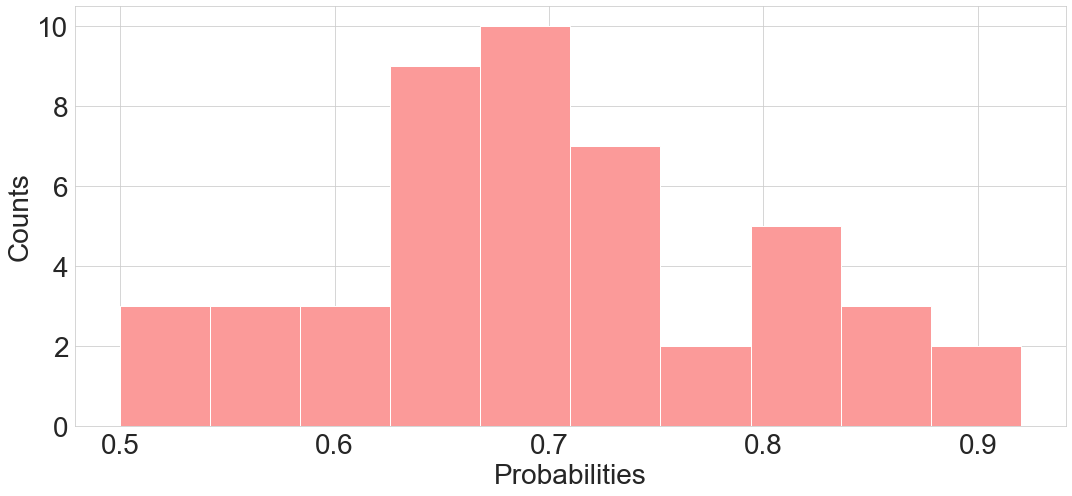

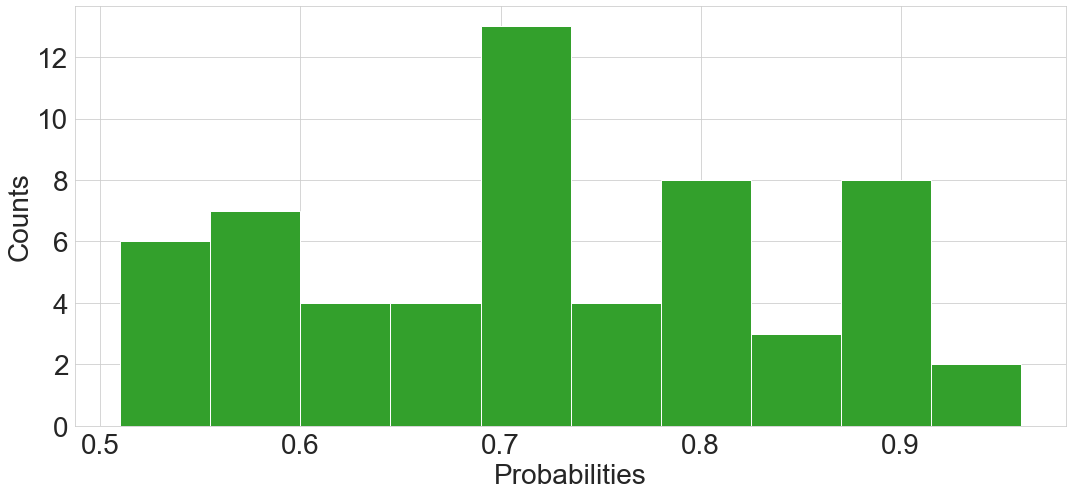

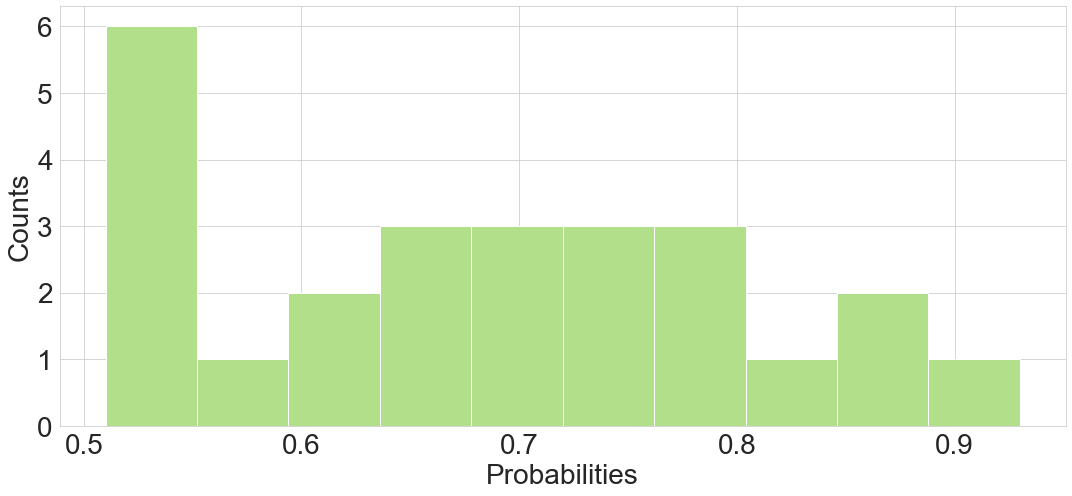

In [127]:
for o in ['tp','fp','tn','fn']:
    plotProbabilities(o, pred_group, font_size=28, save_fig=True)

Observed image class:  Probable/Possible
Loss output:  tf.Tensor([[-0.34770903  0.4402128 ]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=0.4402128>]
Probability of prediction:  ['0.69']
Predicted class:  ['Probable/Possible']
[array([0.31261507, 0.68738496], dtype=float32)]
(336, 336, 3)
Shape of heatmap matrix: (336, 336)
tp
Probable/Possible


array([[[  0,   0, 150],
        [  0,   0, 195],
        [  0,   0, 245],
        ...,
        [ 76, 255, 170],
        [137, 255, 108],
        [195, 255,  50]],

       [[  0,   0, 154],
        [  0,   0, 195],
        [  0,   0, 236],
        ...,
        [ 70, 255, 176],
        [128, 255, 118],
        [186, 255,  60]],

       [[  0,   0, 159],
        [  0,   0, 191],
        [  0,   0, 227],
        ...,
        [ 63, 255, 183],
        [118, 255, 128],
        [173, 255,  73]],

       ...,

       [[  0,   0, 177],
        [  0,   0, 186],
        [  0,   0, 195],
        ...,
        [  0,  32, 255],
        [  0,  32, 255],
        [  0,  28, 255]],

       [[  0,   0, 177],
        [  0,   0, 182],
        [  0,   0, 191],
        ...,
        [  0,   8, 255],
        [  0,   4, 255],
        [  0,   4, 255]],

       [[  0,   0, 177],
        [  0,   0, 182],
        [  0,   0, 186],
        ...,
        [  0,   0, 255],
        [  0,   0, 250],
        [  0,   0, 245]]

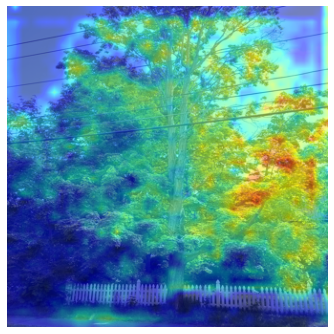

In [22]:
renderGradCam(tp[0][0])

In [ ]:
def plotVisualizations(index, activation_layer='conv2d_4', c_map='gist_gray', save=False):
    subplot_args = { 'nrows': 4, 'ncols': 4, 'figsize': (15, 15), 
                    'subplot_kw': {'xticks': [], 'yticks': []} }
    grid_dir = '../../figures/'
    plot_name = 'plot_grid_'+str(index)
    f, axs = plt.subplots(**subplot_args)
    f.set_facecolor("white")
    axis_labels = ['Processed Input', 'GradCAM', 'Guided Backprop', 'Guided GradCAM']
    orig_image = validation_images[index]
    gcam_heatmap = renderGradCam(index, False, True)    
    gbp = renderGBP(index, activation_layer, False, True)
    ggcam = renderGGCAM(index, activation_layer, False, True)
    f.suptitle('Observed: ' + class_labels[np.argmax(validation_labels[index])]+ '. Predicted: ' + str(grad_cam([index])[3])[2:-2]+'. Probability: '+str("{:.0%}".format(float(str(grad_cam([index])[2])[2:-2])))+'.', y=0.595, fontsize=24, va='bottom') 
    axs[0].imshow(np.squeeze(orig_image))
    axs[1].imshow(np.squeeze(orig_image))
    axs[1].imshow(gcam_heatmap, cmap=c_map, alpha=0.5)
    axs[2].imshow(gbp, cmap=c_map)
    axs[3].imshow(ggcam, cmap=c_map)
    for axis in f.axes:
        axis.set_axis_on()
        axis.set_xticks([])
        axis.set_yticks([])
        axis.spines["top"].set_visible(False)
        axis.spines["right"].set_visible(False)
        axis.spines["left"].set_visible(False)
        axis.spines["bottom"].set_visible(False)        
    for i, axis in enumerate(f.axes):
        axis.set_xlabel(axis_labels[i], fontsize=18)
    f.tight_layout(rect=[0, 0, 1, 0.95])
    if save:
        f.savefig(grid_dir+plot_name, bbox_inches='tight')
        print('Saving '+plot_name+' in '+grid_dir)
    return 

In [19]:
for r in rates:
    get_summary_statistics(r)
    print('\n')

ValueError: could not convert string to float: 'T'

In [276]:
len(fn[0])

47

In [45]:
for r in rates:
    print(Counter(r).most_common(),'\n')

[('0.98', 6), ('1.0', 5), ('0.99', 4), ('0.85', 3), ('0.84', 2), ('0.8', 2), ('0.94', 2), ('0.79', 2), ('0.91', 2), ('0.97', 1), ('0.9', 1), ('0.75', 1), ('0.63', 1), ('0.6', 1), ('0.76', 1), ('0.74', 1), ('0.92', 1), ('0.52', 1), ('0.93', 1), ('0.59', 1), ('0.83', 1), ('0.66', 1), ('0.95', 1)] 

[('0.94', 3), ('0.9', 2), ('0.85', 2), ('0.92', 1), ('0.52', 1), ('0.72', 1), ('0.87', 1), ('0.83', 1), ('0.97', 1), ('0.66', 1), ('0.99', 1), ('0.82', 1), ('0.73', 1), ('0.68', 1), ('0.95', 1), ('0.64', 1), ('0.96', 1), ('0.77', 1), ('0.62', 1)] 

[('0.99', 5), ('0.95', 4), ('1.0', 3), ('0.96', 3), ('0.97', 3), ('0.8', 3), ('0.91', 3), ('0.92', 3), ('0.79', 2), ('0.73', 2), ('0.62', 2), ('0.84', 2), ('0.56', 2), ('0.5', 2), ('0.9', 2), ('0.71', 1), ('0.54', 1), ('0.72', 1), ('0.58', 1), ('0.57', 1), ('0.83', 1), ('0.85', 1), ('0.78', 1), ('0.63', 1), ('0.81', 1), ('0.66', 1), ('0.77', 1), ('0.88', 1), ('0.51', 1), ('0.7', 1), ('0.68', 1), ('0.74', 1), ('0.89', 1)] 

[('0.97', 5), ('0.92', 4),

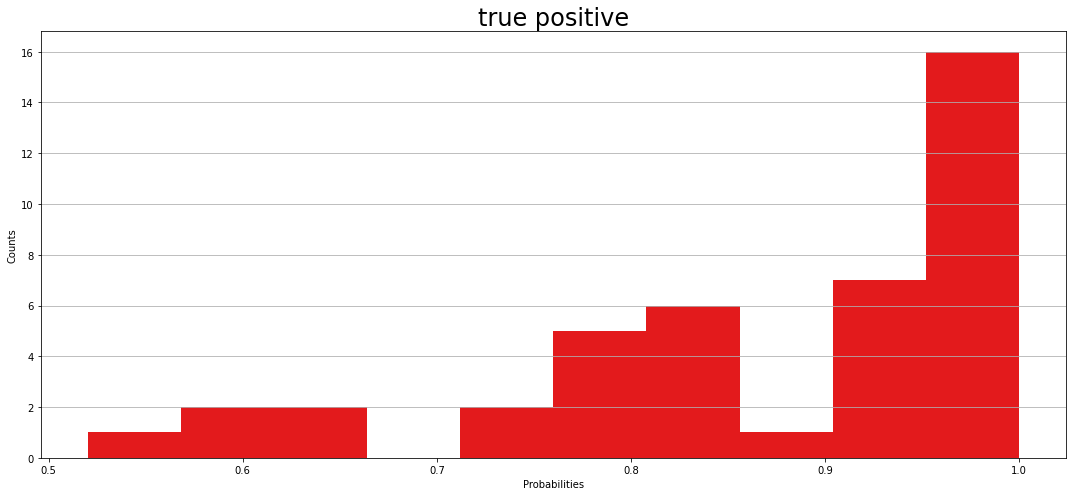

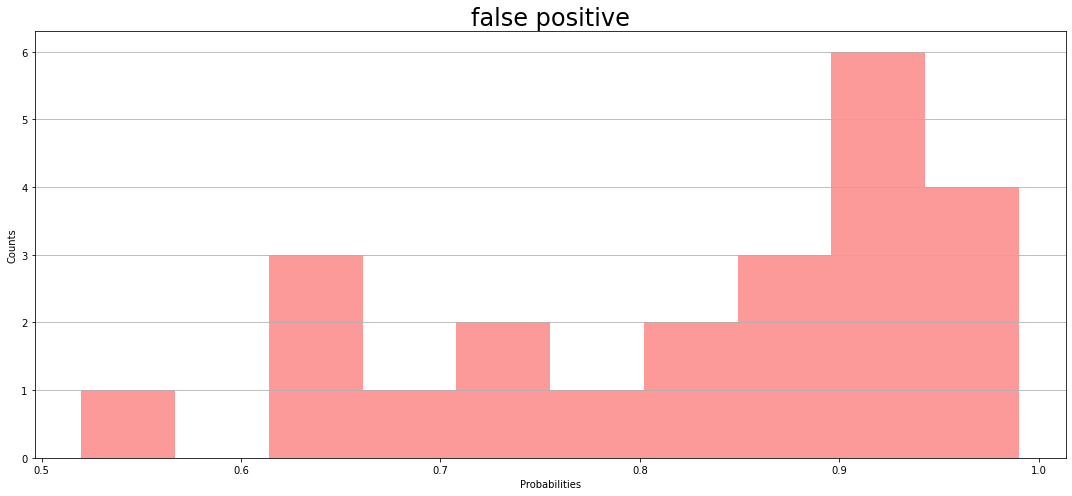

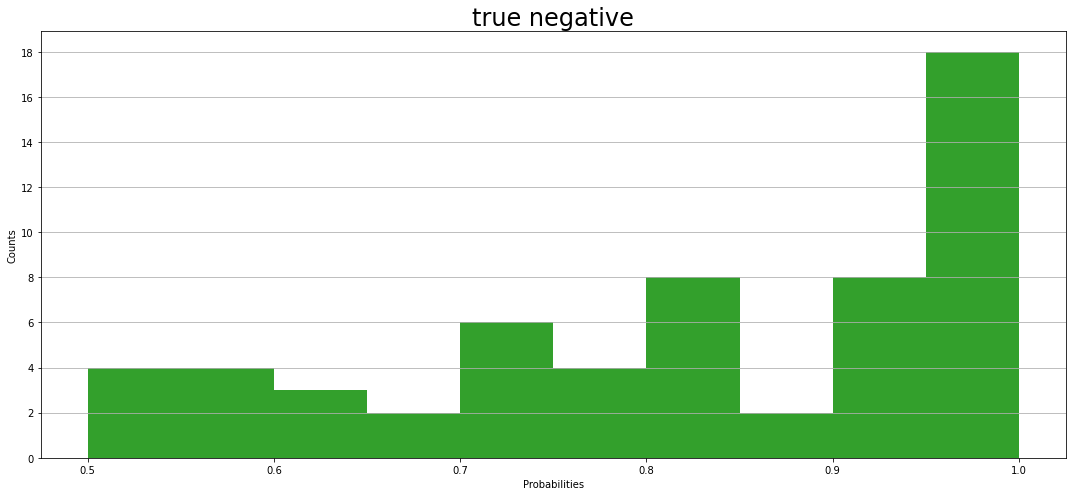

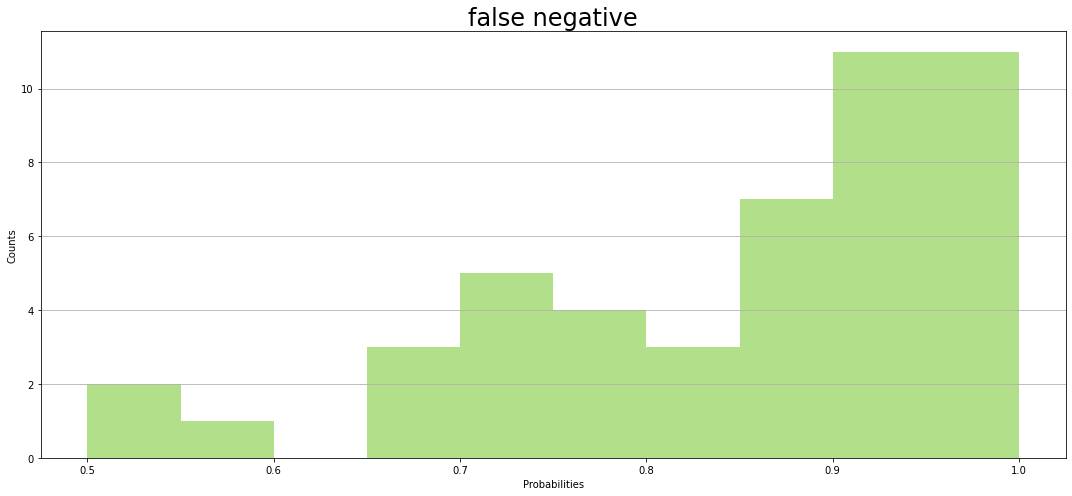

In [44]:
for l in ['tp','fp','tn','fn']:
    plotProbabilities(l, 10, True)

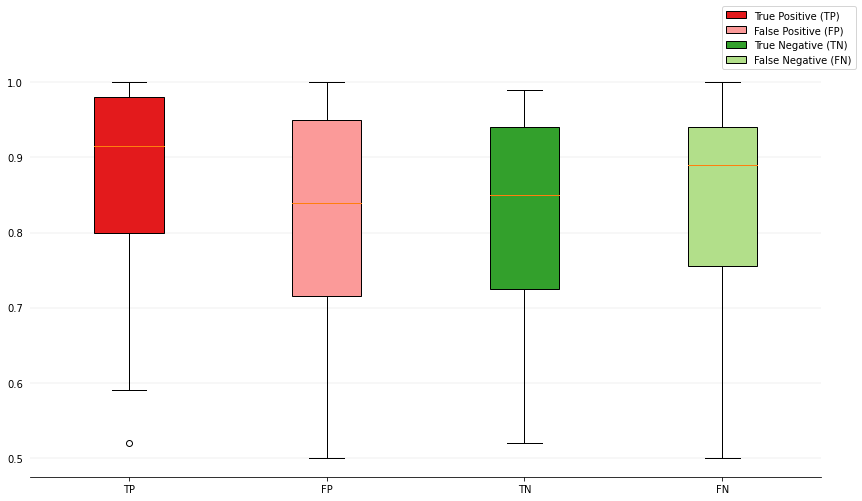

In [122]:
plotPredictionProbabilities()

In [26]:
tp1 = [float(x) for x in tp]
tn1 = [float(x) for x in tn]
fp1 = [float(x) for x in fp]
fn1 = [float(x) for x in fn]

In [29]:
tp1

[106.0,
 107.0,
 109.0,
 113.0,
 114.0,
 115.0,
 116.0,
 117.0,
 118.0,
 119.0,
 120.0,
 121.0,
 123.0,
 124.0,
 127.0,
 129.0,
 130.0,
 134.0,
 137.0,
 138.0,
 139.0,
 140.0,
 141.0,
 142.0,
 143.0,
 144.0,
 145.0,
 147.0,
 148.0,
 149.0,
 150.0,
 151.0,
 153.0,
 154.0,
 155.0,
 158.0,
 162.0,
 166.0,
 167.0,
 168.0,
 169.0,
 170.0]

In [19]:
grad_cam([tp1[10]])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [109]:
print(min([float(x) for x in tp]))

0.52


In [10]:
obj1 = grad_cam([10])

Observed image class:  Improbable
Loss output:  tf.Tensor([[-1.3862385  1.1933436]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=-1.3862385>]
Probability of prediction:  ['0.93']
Predicted class:  ['Probable/Possible']
[array([0.0704641 , 0.92953587], dtype=float32)]
(336, 336, 3)
Shape of heatmap matrix: (336, 336)


In [39]:
grad_cam([10])[2][0]

Observed image class:  Improbable
Loss output:  tf.Tensor([[-0.01835316  0.01353806]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=-0.01835316>]
Probability of prediction:  ['0.51']
Predicted class:  ['Probable/Possible']
[array([0.49202788, 0.50797206], dtype=float32)]
(336, 336, 3)
Shape of heatmap matrix: (336, 336)


'0.51'

In [104]:
Counter(tp).most_common(1)[0][1]

19

In [18]:
# class_labels[0] -> improbable; class_labels[1] -> probable/possible
print("Total number of test images:", len(test_images),'\n')
print("Indices of correct", class_labels[1], "predictions:", pred_prob[class_labels[1]+'_correct'], 'Total:', len(pred_prob[class_labels[1]+'_correct']), '\n')
print("Indices of correct", class_labels[0], "predictions:", pred_prob[class_labels[0]+'_correct'], 'Total:', len(pred_prob[class_labels[0]+'_correct']),'\n')
print("Indices of incorrect", class_labels[1], "predictions:", pred_prob[class_labels[1]+'_incorrect'], 'Total:', len(pred_prob[class_labels[1]+'_incorrect']),'\n')
print("Indices of incorrect", class_labels[0], "predictions:", pred_prob[class_labels[0]+'_incorrect'], 'Total:', len(pred_prob[class_labels[0]+'_incorrect']),)

Total number of test images: 171 



TypeError: tuple indices must be integers or slices, not str

In [42]:
pred_prob

{'Improbable_correct': ['0.51',
  '0.5',
  '0.5',
  '0.52',
  '0.52',
  '0.52',
  '0.51',
  '0.5',
  '0.51',
  '0.51',
  '0.5',
  '0.51',
  '0.52',
  '0.51',
  '0.5',
  '0.51',
  '0.51',
  '0.51',
  '0.51',
  '0.51',
  '0.5',
  '0.52',
  '0.52',
  '0.53',
  '0.51',
  '0.5',
  '0.51',
  '0.51',
  '0.51',
  '0.5',
  '0.51',
  '0.51',
  '0.51',
  '0.52',
  '0.51',
  '0.5',
  '0.51',
  '0.5',
  '0.5',
  '0.5',
  '0.5',
  '0.5',
  '0.5',
  '0.51',
  '0.5',
  '0.51',
  '0.51',
  '0.51',
  '0.51',
  '0.5',
  '0.51',
  '0.51',
  '0.5',
  '0.51',
  '0.51',
  '0.5'],
 'Improbable_incorrect': ['0.5',
  '0.5',
  '0.51',
  '0.51',
  '0.51',
  '0.5',
  '0.51',
  '0.5',
  '0.51',
  '0.5',
  '0.5',
  '0.5',
  '0.5',
  '0.51',
  '0.5',
  '0.51',
  '0.51',
  '0.51',
  '0.51',
  '0.5',
  '0.5',
  '0.5',
  '0.5',
  '0.5',
  '0.51',
  '0.51',
  '0.5',
  '0.5',
  '0.51',
  '0.51',
  '0.51',
  '0.52',
  '0.5',
  '0.51',
  '0.51',
  '0.51',
  '0.5',
  '0.5',
  '0.51',
  '0.51',
  '0.51',
  '0.51',
  '0.51',
 

In [34]:
tn_fs = sorted([float(x) for x in tn])
tn_fs

[0.5,
 0.5,
 0.51,
 0.54,
 0.56,
 0.56,
 0.57,
 0.58,
 0.62,
 0.62,
 0.63,
 0.66,
 0.68,
 0.7,
 0.71,
 0.72,
 0.73,
 0.73,
 0.74,
 0.77,
 0.78,
 0.79,
 0.79,
 0.8,
 0.8,
 0.8,
 0.81,
 0.83,
 0.84,
 0.84,
 0.85,
 0.88,
 0.89,
 0.9,
 0.9,
 0.91,
 0.91,
 0.91,
 0.92,
 0.92,
 0.92,
 0.95,
 0.95,
 0.95,
 0.95,
 0.96,
 0.96,
 0.96,
 0.97,
 0.97,
 0.97,
 0.99,
 0.99,
 0.99,
 0.99,
 0.99,
 1.0,
 1.0,
 1.0]

In [51]:
tp_fs

[0.52,
 0.59,
 0.6,
 0.63,
 0.66,
 0.74,
 0.75,
 0.76,
 0.79,
 0.79,
 0.8,
 0.8,
 0.83,
 0.84,
 0.84,
 0.85,
 0.85,
 0.85,
 0.9,
 0.91,
 0.91,
 0.92,
 0.93,
 0.94,
 0.94,
 0.95,
 0.97,
 0.98,
 0.98,
 0.98,
 0.98,
 0.98,
 0.98,
 0.99,
 0.99,
 0.99,
 0.99,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [81]:
Counter(tp_fs).most_common()[0][1]

6

In [225]:
[np.round(float(x), 2) for x in tp]

[0.52,
 0.59,
 0.6,
 0.63,
 0.66,
 0.74,
 0.75,
 0.76,
 0.79,
 0.79,
 0.8,
 0.8,
 0.83,
 0.84,
 0.84,
 0.85,
 0.85,
 0.85,
 0.9,
 0.91,
 0.91,
 0.92,
 0.93,
 0.94,
 0.94,
 0.95,
 0.97,
 0.98,
 0.98,
 0.98,
 0.98,
 0.98,
 0.98,
 0.99,
 0.99,
 0.99,
 0.99,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

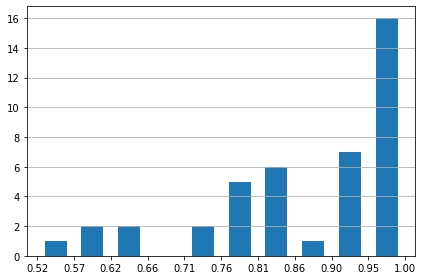

In [25]:
# plt.figure(figsize=(12,7))
fig, ax = plt.subplots()
counts, bins, patches = ax.hist(sorted([float(x) for x in tp]), rwidth=.6)
ax.set_xticks(bins)
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.2f'))
ax.grid(which='major', axis='y', zorder=-1.0)
fig.tight_layout()
plt.savefig('../../figures/histogram_tp_freq.jpg')
# tp_fs = sorted([float(x) for x in tp])
# plt.hist(tp_fs, bins=50)
# plt.yticks(np.arange(Counter(tp_fs).most_common()[-1][1], 
#                      Counter(tp_fs).most_common()[0][1], 2))

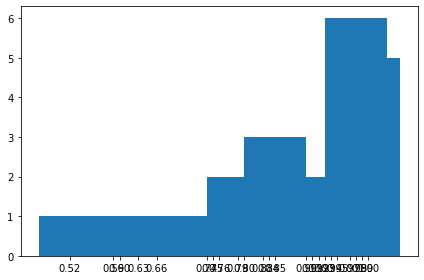

In [265]:
facecolor = '#EAEAEA'
color_bars = '#3475D0'
data = sorted([float(x) for x in tp])
labels, counts = np.unique(data, return_counts=True)
plt.bar(labels, counts, align='center', width=0.1)
plt.gca().set_xticks(labels)
plt.show()

In [259]:
counts

array([1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 3, 1, 2, 1, 1, 2, 1, 1, 6, 4,
       5], dtype=int64)

In [60]:
fig = fig.get_figure()
fig.savefig('../../figures/prpo_correct_predictions_density.jpg')